In [58]:
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
from omegaconf import OmegaConf
from tqdm.notebook import tqdm, trange
from utils.data import load_xyz_file
# from utils.losses import density_chamfer_dist
# from utils.losses import chamfer_dist, density_chamfer_dist
from utils.chamfer_distance import chamfer_dist, density_chamfer_dist
from utils.viz import (
    draw_point_cloud,
    point_cloud_three_views,
    viz_many,
    viz_many_mpl,
    viz_pcd_graph,
)

# Load model

Load a model from checkpoint and evaluate with it 

In [59]:
sorted(os.listdir("trained-models/"))

['2025-04-08-14-29-pugcn-baseline',
 '2025-04-08-14-36-pugcn-baseline',
 '2025-04-08-14-40-pugcn-baseline',
 '2025-04-08-16-20-pugcn-baseline',
 '2025-04-08-16-54-pugcn-baseline']

In [60]:
# d = os.listdir(os.path.join("trained-models"))[0]
ckpt_dir = sorted(os.listdir("trained-models"))[-1]
# ckpt_dir = "2022-06-07-13-18-ju-baseline2"

In [8]:
ckpt_dir

'2025-04-08-16-54-pugcn-baseline'

In [9]:
os.listdir(os.path.join("trained-models", ckpt_dir))

['ckpt_epoch_5', 'ckpt_epoch_10', 'config.yaml', 'ckpt_epoch_1']

In [10]:
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
print(exp_conf)

{'name': 'pugcn-baseline', 'model_config': {'r': 4, 'k': 16, 'dilations': [1, 2, 4], 'n_idgcn_blocks': 3, 'channels': 64, 'n_dgcn_blocks': 3, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'mean', 'dynamic': False, 'use_refiner': False, 'upsampler': 'nodeshuffle', 'hierarchical': False}, 'train_config': {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'save_every': 5, 'augment': True, 'loss_fn': 'cd', 'k_loss': 4}, 'data_config': {'path': './data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5', 'num_point': 256, 'skip_rate': 1, 'use_randominput': True, 'rng_seed': 42}}


In [11]:
ckpt_name = "ckpt_epoch_10"

In [12]:
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))

In [13]:
history = OmegaConf.create(checkpoint["history"])

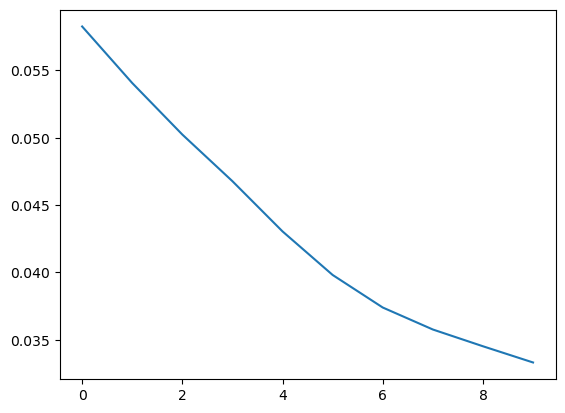

In [14]:
plt.plot(history.train_loss)

In [15]:
model_config = exp_conf.model_config

In [16]:
model_config

{'r': 4, 'k': 16, 'dilations': [1, 2, 4], 'n_idgcn_blocks': 3, 'channels': 64, 'n_dgcn_blocks': 3, 'use_bottleneck': True, 'use_pooling': True, 'use_residual': True, 'conv': 'edge', 'pool_type': 'mean', 'dynamic': False, 'use_refiner': False, 'upsampler': 'nodeshuffle', 'hierarchical': False}

In [17]:
from pugcn_lib.models import PUGCN, JustUpsample, PUInceptionTransformer

In [19]:
model = PUGCN(**model_config)
# model = PUInceptionTransformer(**model_config)
# model = JustUpsample(**model_config)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

# Qualitative

In [23]:
input_dir = os.path.join(".", "data", "PU1K", "test", "input_256", "input_256")
gt_dir = os.path.join(".", "data", "PU1K", "test", "input_256", "gt_1024")

In [24]:
file = "m32" + ".xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)

In [25]:
out = model(data).detach()

In [26]:
# o3d
viz_many([data.numpy(), gt.numpy(), out.numpy()])

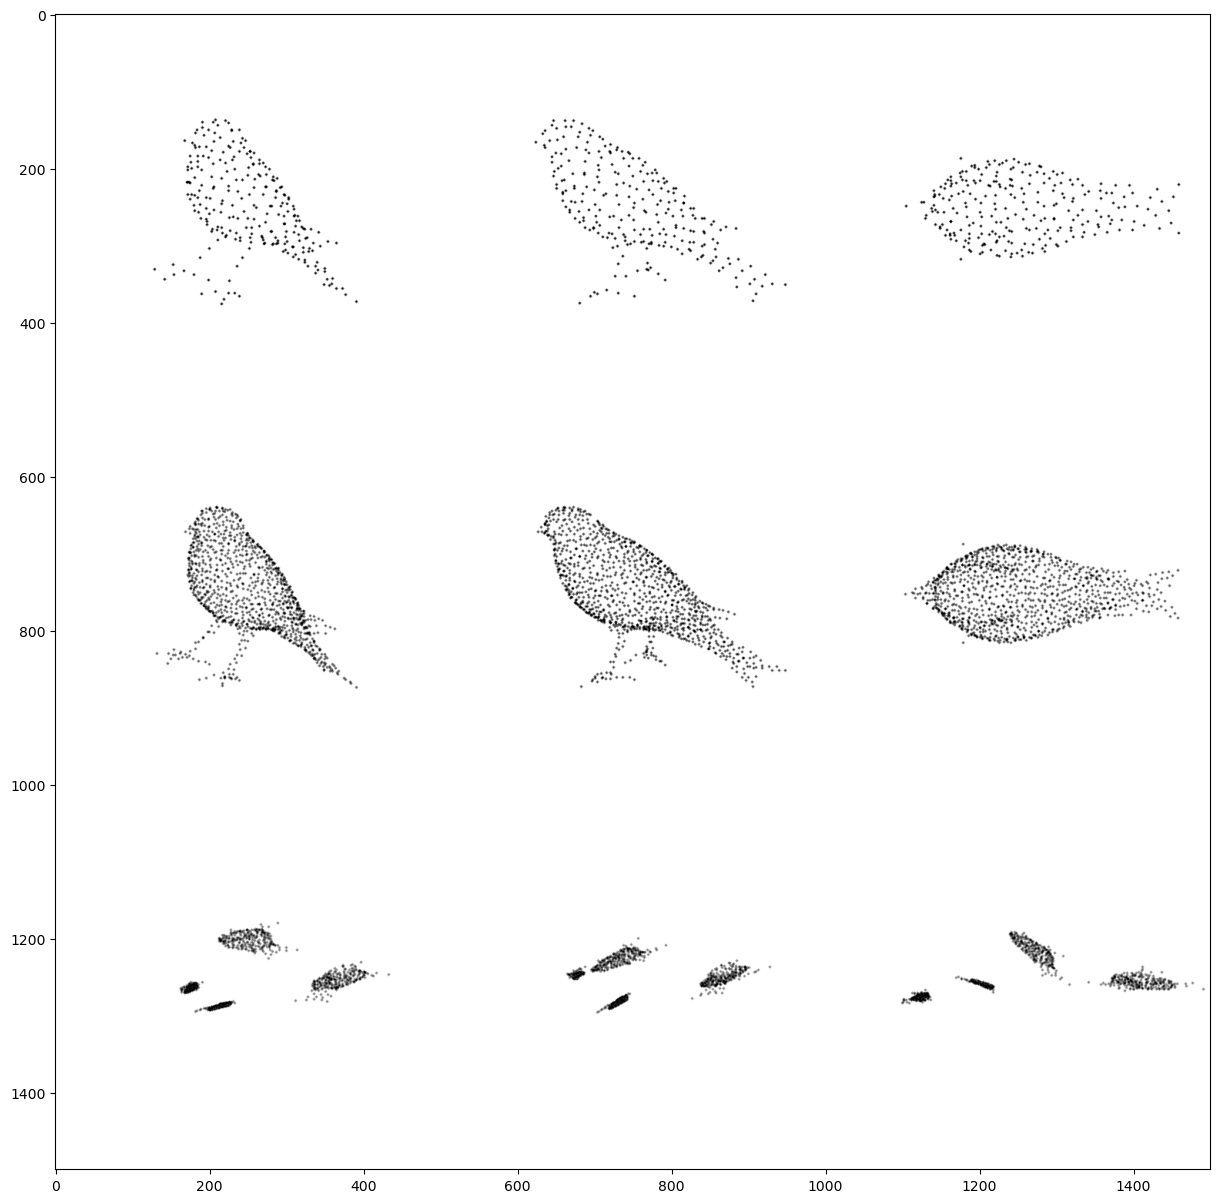

In [27]:
fig = plt.figure(figsize=(15, 15))
img_data = point_cloud_three_views(data.numpy())
img_gt = point_cloud_three_views(gt.numpy())
img_out = point_cloud_three_views(out.numpy())
plt.imshow(np.concatenate([img_data, img_gt, img_out]), cmap="gray")

In [48]:
# v.capture_screen_image("test.png")

In [28]:
from torch_geometric.nn import knn_graph

k = 5
edge_index = knn_graph(data, k)
edge_index.shape

torch.Size([2, 1280])

In [29]:
viz_many([data])

In [30]:
# Viz
viz_pcd_graph(data, edge_index.T.tolist())

# Quantitative

In [31]:
import torch
from einops import rearrange, reduce
# from gcn_lib.sparse.torch_edge import Dilated

In [64]:
from time import time

from utils.losses import (
    hausdorff_loss,
)

from utils.chamfer_distance import chamfer_dist, density_chamfer_dist

In [66]:
chamfer_losses = []
hausdorff_losses = []
dcds = []
for file in tqdm(os.listdir(input_dir)):
    # Load files
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    # predict
    t = time()
    out = model(data)
    t = time() - t

    # # chamfer
    dcd, _, cd = density_chamfer_dist(out.unsqueeze(0), gt.unsqueeze(0), alpha=1000, n_lambda=0.5)
    chamfer_losses.append(cd.item())
    dcds.append(dcd.item())

    # hausdorff

    loss = hausdorff_loss(out.detach(), gt.detach())
    hausdorff_losses.append(loss)

  0%|          | 0/127 [00:00<?, ?it/s]

In [67]:
print("CD = ", np.mean(chamfer_losses) * 10**3)
print("DCD = ", np.mean(dcds))
print("HD = ", np.mean(hausdorff_losses) * 10**3)
print("Inference time = ", t * 1000)
print("Model size = ", checkpoint["model_size"])

CD =  423.1226852559668
DCD =  0.9999800366679514
HD =  591.8888134749517
Inference time =  36.492109298706055
Model size =  332.012


In [68]:
t = OmegaConf.create(
    {
        "epochs_trained": checkpoint["epoch"],
        "chamfer_loss": float(np.mean(chamfer_losses) * 10**3),
        "density_aware_chamfer_loss": float(np.mean(dcds) * 10**3),
        "hausdorff_loss": float(np.mean(hausdorff_losses) * 10**3),
        "model_size": checkpoint["model_size"],
        "inference_time": t,
    }
)

In [69]:
print(OmegaConf.to_yaml(exp_conf))

name: pugcn-baseline
model_config:
  r: 4
  k: 16
  dilations:
  - 1
  - 2
  - 4
  n_idgcn_blocks: 3
  channels: 64
  n_dgcn_blocks: 3
  use_bottleneck: true
  use_pooling: true
  use_residual: true
  conv: edge
  pool_type: mean
  dynamic: false
  use_refiner: false
  upsampler: nodeshuffle
  hierarchical: false
train_config:
  batch_size: 64
  epochs: 10
  optimizer: adam
  lr: 0.001
  betas:
  - 0.9
  - 0.999
  save_every: 5
  augment: true
  loss_fn: cd
  k_loss: 4
data_config:
  path: ./data/PU1K/train/pu1k_poisson_256_poisson_1024_pc_2500_patch50_addpugan.h5
  num_point: 256
  skip_rate: 1
  use_randominput: true
  rng_seed: 42
results:
  epochs_trained: 10
  chamfer_loss: .nan
  density_aware_chamfer_loss: .nan
  hausdorff_loss: 591.8888134749517
  model_size: 332.012
  inference_time: 0.058148860931396484



In [70]:
results = exp_conf
results.results = t


In [71]:
OmegaConf.save(config=results, f=os.path.join("results", f"results-{ckpt_dir}-{ckpt_name}.yaml"))

# Compare qualitative

In [72]:
def plot_horizontal(pcds, titles, savefile=None, show=True, figsize=5):

    img_arr = [
        draw_point_cloud(data.numpy(), zrot=110 / 180.0 * np.pi, xrot=135 / 180.0 * np.pi, diameter=5) for data in pcds
    ]
    plt.figure(figsize=(figsize * len(titles), figsize))

    for i, (img, title) in enumerate(zip(img_arr, titles), start=1):
        plt.subplot(1, len(img_arr), i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(title)

    if savefile is not None:
        plt.savefig(savefile)

    if show:
        plt.show()

## Best and worst

In [73]:
best_idx = np.argmin(chamfer_losses)
worst_idx = np.argmax(chamfer_losses)

In [74]:
file = os.listdir(input_dir)[best_idx]
# file = "horse.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)
out = model(data).detach()

<Figure size 1080x1080 with 0 Axes>

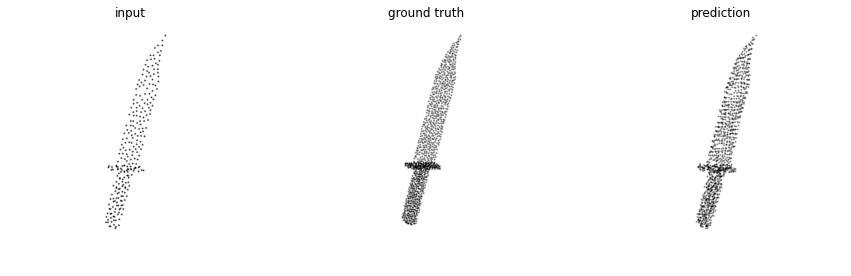

In [36]:
fig = plt.figure(figsize=(15, 15))
img_data = draw_point_cloud(data.numpy(), zrot=110 / 180.0 * np.pi, xrot=135 / 180.0 * np.pi, diameter=5)
img_gt = draw_point_cloud(gt.numpy(), zrot=110 / 180.0 * np.pi, xrot=135 / 180.0 * np.pi, diameter=5)
img_out = draw_point_cloud(out.numpy(), zrot=110 / 180.0 * np.pi, xrot=135 / 180.0 * np.pi, diameter=5)

img_arr = [img_data, img_gt, img_out]
img_titles = ["input", "ground truth", "prediction"]
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(img_arr, img_titles), start=1):
    plt.subplot(1, len(img_arr), i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(title)

plt.show()

In [44]:
exp_conf.name

'pugcn-baseline'

In [75]:
for file in tqdm(os.listdir(input_dir)):
    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    out = model(data).detach()

    img_dir = os.path.join("images", "images_data_gt_prediction")
    if exp_conf.name not in os.listdir(img_dir):
        os.mkdir(os.path.join(img_dir, exp_conf.name))
    savefile = os.path.join(img_dir, exp_conf.name, ".".join(file.split(".")[:-1]) + ".png")
    plot_3(data, gt, out, savefile=savefile, show=False)

  0%|          | 0/127 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'images/images_data_gt_prediction'

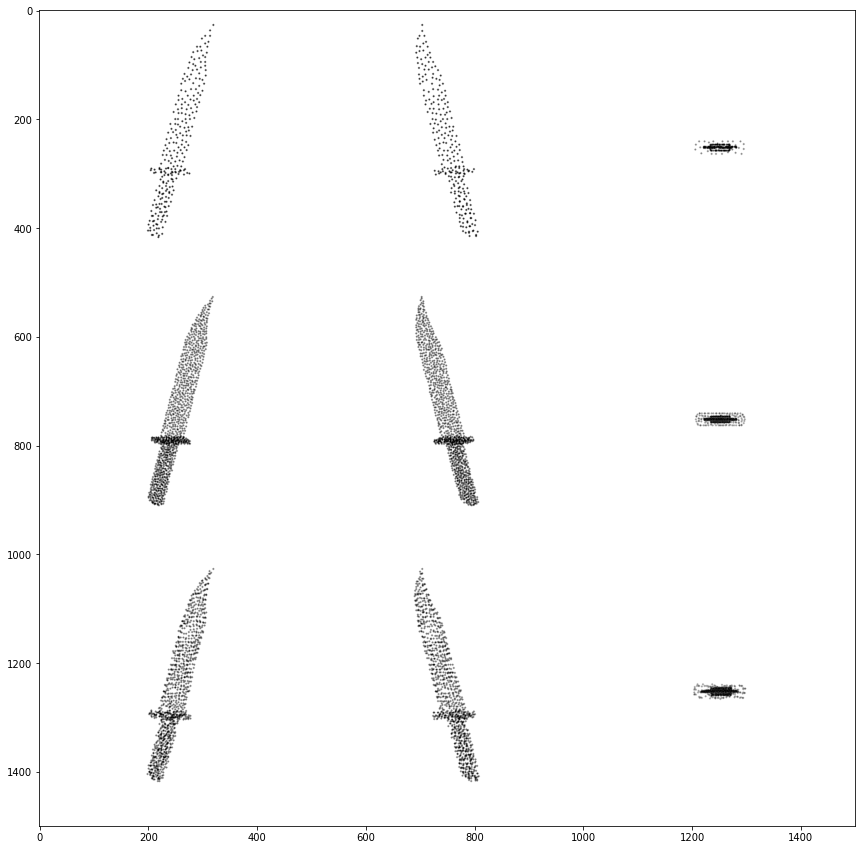

In [38]:
fig = plt.figure(figsize=(15, 15))
img_data = point_cloud_three_views(data.numpy())
img_gt = point_cloud_three_views(gt.numpy())
img_out = point_cloud_three_views(out.numpy())
plt.imshow(np.concatenate([img_data, img_gt, img_out]), cmap="gray")

## Compare with other models

In [46]:
from pugcn_lib.models import PUGCN, JustUpsample

In [76]:
ckpt_dir = "2022-06-06-15-04-pugcn-baseline"
ckpt_name = "ckpt_epoch_10"
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
model_config = exp_conf.model_config

FileNotFoundError: [Errno 2] No such file or directory: 'trained-models/2022-06-06-15-04-pugcn-baseline/ckpt_epoch_10'

In [14]:
model1 = PUGCN(**model_config)
# model = PUInceptionTransformer(**model_config)
# model = JustUpsample(**model_config)

model1.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [16]:
ckpt_dir = "2022-06-06-19-23-pugcn-baseline-alpha05"
ckpt_name = "ckpt_epoch_10"
checkpoint = torch.load(os.path.join("trained-models", ckpt_dir, ckpt_name))
exp_conf = OmegaConf.load(os.path.join("trained-models", ckpt_dir, "config.yaml"))
model_config = exp_conf.model_config

In [17]:
model2 = PUGCN(**model_config)
# model = PUInceptionTransformer(**model_config)
# model = JustUpsample(**model_config)

model2.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [20]:
file = os.listdir(input_dir)[-10]
file = "04225987.95c69877104059fd1389cf37af584e4b.xyz"
data = load_xyz_file(os.path.join(input_dir, file))
gt = load_xyz_file(os.path.join(gt_dir, file))
data = torch.tensor(data, dtype=torch.float32)
gt = torch.tensor(gt, dtype=torch.float32)
out1 = model1(data).detach()
out2 = model2(data).detach()

/home/zademn/.conda/envs/pytorch_env/lib/python3.9/site-packages/einops/einops.py:202: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  inferred_length: int = length // known_product


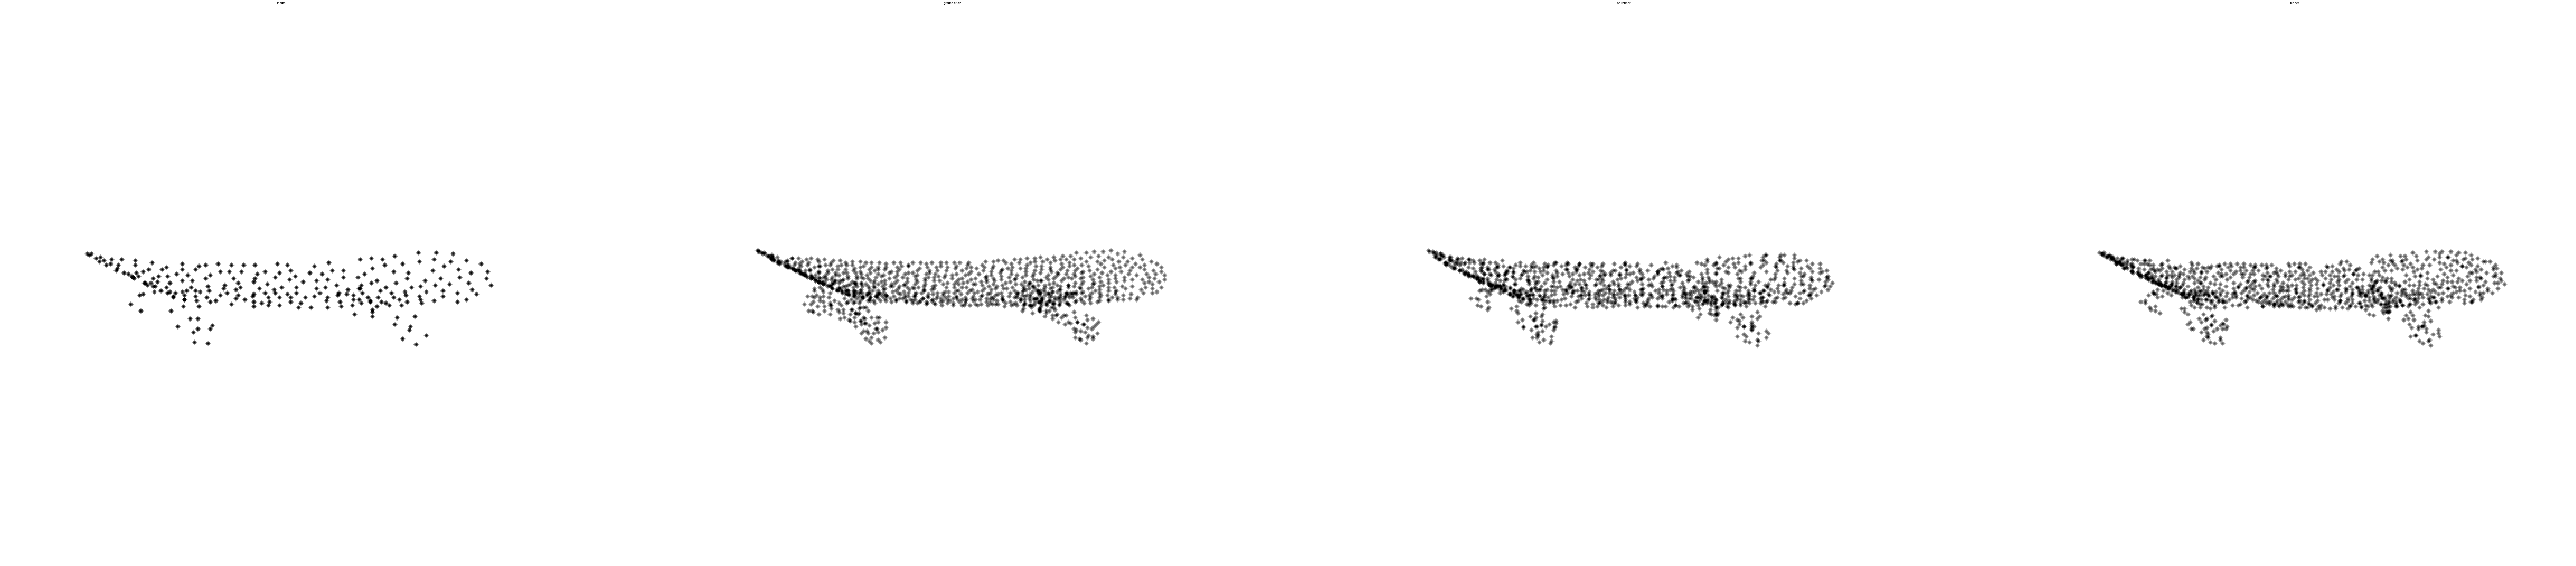

In [24]:
plot_horizontal(
    [data, gt, out1, out2], ["inputs", "ground truth", "no refiner", "refiner"], figsize=50, savefile="test.png"
)

In [ ]:
img_dir = os.path.join("images", "images_data_gt_prediction")
dir_name = "cd-vs-cdrep16"

if dir_name not in os.listdir(img_dir):
    os.mkdir(os.path.join(img_dir, dir_name))
for file in tqdm(os.listdir(input_dir)):

    data = load_xyz_file(os.path.join(input_dir, file))
    gt = load_xyz_file(os.path.join(gt_dir, file))
    data = torch.tensor(data, dtype=torch.float32)
    gt = torch.tensor(gt, dtype=torch.float32)
    out1 = model1(data).detach()
    out2 = model2(data).detach()
    savefile = os.path.join(img_dir, dir_name, ".".join(file.split(".")[:-1]) + ".png")
    img_titles = ["input", "ground truth", "cd", "cd-rep16"]
    plot_horizontal([data, gt, out1, out2], img_titles, show=True, savefile=savefile)

# Add noise